In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import winsound
import random

df= pd.read_csv("../../data/processed/oline_merge.csv")
df = df[df.year >= df.draft_yr+4]
df =df[df.year != 2020]
len(df)

df = df.drop('year',axis=1)
df = df.drop('playername',axis=1)
df = df.drop('team',axis=1)
df = df.drop('basesalarycap (10^8)',axis=1)
df = df.drop('cashspent (M)',axis=1)
df = df.drop('caphit (M)',axis=1)
df = df.drop('Unnamed: 0',axis=1)
df = df.drop('Unnamed: 0.1',axis=1)
df = df.drop('catchpercent',axis=1)
df = df.drop('draft_yr',axis=1)

df = df.drop('yardspergame_run',axis=1)
df = df.drop('yardsperatt',axis=1)
df = df.drop('yardspertarget',axis=1)
df = df.drop('yardsperrec',axis=1)
df = df.drop('recpergame',axis=1)
df = df.drop('yardspergame_rec',axis=1)


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

X = df.drop('Percenthit (%)',axis=1).values
y = df['Percenthit (%)'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

loaded_model = tf.keras.models.load_model('./savedmodels/norookiednn/')
predictions = loaded_model.predict(X_test)

print("MSE: ",mean_squared_error(y_test,predictions) )
print("RMSE: ",np.sqrt(mean_squared_error(y_test,predictions)) )
print("MAE: ",mean_absolute_error(y_test,predictions) )
print("ESV: ", explained_variance_score(y_test, predictions))

MSE:  2.735906130222005
RMSE:  1.6540574748847168
MAE:  1.249584093130343
ESV:  0.518537618315993


Model: "sequential_417"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2025 (Dense)           (None, 18)                342       
_________________________________________________________________
dense_2026 (Dense)           (None, 40)                760       
_________________________________________________________________
dense_2027 (Dense)           (None, 40)                1640      
_________________________________________________________________
dense_2028 (Dense)           (None, 40)                1640      
_________________________________________________________________
dense_2029 (Dense)           (None, 1)                 41        
Total params: 4,423
Trainable params: 4,423
Non-trainable params: 0
_________________________________________________________________


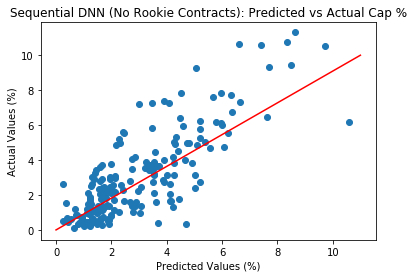

In [2]:
loaded_model = tf.keras.models.load_model('./savedmodels/norookiednn/')
loaded_model.summary()

X_scl = scaler.fit_transform(X)
predictions = loaded_model.predict(X_scl)
plt.scatter(predictions,y)

plt.ylabel("Actual Values (%)")
plt.xlabel("Predicted Values (%)")
plt.title('Sequential DNN (No Rookie Contracts): Predicted vs Actual Cap %')
plt.plot(np.linspace(0,11,100),np.linspace(0,10,100), 'r-')


Model: "sequential_158"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_790 (Dense)            (None, 18)                342       
_________________________________________________________________
dense_791 (Dense)            (None, 6)                 114       
_________________________________________________________________
dense_792 (Dense)            (None, 6)                 42        
_________________________________________________________________
dense_793 (Dense)            (None, 6)                 42        
_________________________________________________________________
dense_794 (Dense)            (None, 1)                 7         
Total params: 547
Trainable params: 547
Non-trainable params: 0
_________________________________________________________________
MSE:  3.635005560901175
RMSE:  1.9065690548472602
MAE:  1.409335489477504
ESV:  0.4003292116237783


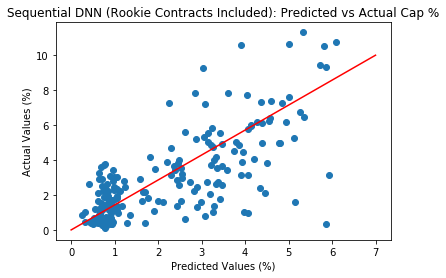

In [3]:
loaded_model = tf.keras.models.load_model('./savedmodels/April13-65dnn')
loaded_model.summary()

predictions = loaded_model.predict(X_test)

print("MSE: ",mean_squared_error(y_test,predictions) )
print("RMSE: ",np.sqrt(mean_squared_error(y_test,predictions)) )
print("MAE: ",mean_absolute_error(y_test,predictions) )
print("ESV: ", explained_variance_score(y_test, predictions))


X_scl = scaler.fit_transform(X)
predictions = loaded_model.predict(X_scl)
plt.scatter(predictions,y)

plt.ylabel("Actual Values (%)")
plt.xlabel("Predicted Values (%)")
plt.title('Sequential DNN (Rookie Contracts Included): Predicted vs Actual Cap %')
plt.plot(np.linspace(0,7,100),np.linspace(0,10,100), 'r-')


# PCA

In [4]:
# These are the standard imports for CS 111
# This list may change as the quarter goes on

import os
import time
import math

import numpy as np
import numpy.linalg as npla

from scipy import linalg as spla
import scipy.sparse
import scipy.sparse.linalg
from scipy import integrate

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

In [5]:
df

,age,draft_pos,attempts,yards_run,tds_run,longgain_run,Percenthit (%),g,gs,tgt,rec,yards_rec,tds_rec,firstdowns,longgain_rec,fumbles,team_adjusted_line_yards,team_running_back_yards,team_stuffed_rate
5,34,7,211,898,5,32,0.945802,15,15,23,17,142,0,7,22,3,18,15,17
6,33,7,251,1042,7,90,0.355530,16,16,26,20,208,1,9,52,3,26,23,28
7,31,7,37,72,0,13,7.728473,3,3,6,3,8,0,0,7,1,30,32,26
8,30,7,327,1485,11,80,10.748185,16,16,36,30,222,0,9,49,7,10,4,12
9,29,7,21,75,0,17,9.268023,1,1,3,2,18,0,1,9,0,13,15,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,30,257,133,548,4,30,0.540993,16,1,26,22,200,1,11,50,0,1,9,2
560,29,257,96,375,4,26,0.216154,8,3,13,12,129,0,7,27,0,13,18,14
562,25,10,223,857,12,25,4.888417,15,15,49,31,207,2,8,23,3,19,26,26
575,32,257,11,23,0,6,1.195122,16,7,20,11,47,1,3,12,1,32,32,32


In [6]:
df['test'] = df['age']*df['attempts']

In [7]:
X = df.drop('Percenthit (%)',axis=1).values

In [8]:
cols = df.drop('Percenthit (%)',axis=1).columns

In [9]:
D=X
(n, p) = X.shape
mu = np.mean( D, axis=0 )                     # 1-by-p row vector of column mean values.
M = np.outer( np.ones( (n, 1) ), mu )         # n-by-p matrix of stacked row mean vectors.
Z = (D-M)/np.std(D)

C = np.cov( Z.T , bias=True )    

U, sigma, Vt = spla.svd( C )
evals, evecs = spla.eigh( C )


In [10]:
len(cols)


19

In [11]:
for i in range( 0, n, 15 ):
    for j in range( p ):
        print( "%.3f"%Z[i, j], end="\t" )
    print( y[i] )

0.005	-0.084	0.050	0.222	0.000	-0.006	0.002	0.006	-0.013	-0.010	-0.069	-0.001	-0.003	-0.006	0.001	0.000	-0.003	0.001	2.498	0.945802338
-0.001	0.023	-0.013	-0.134	-0.001	-0.014	-0.004	-0.000	-0.008	-0.007	-0.103	-0.001	-0.006	-0.013	0.001	0.011	0.010	0.013	-0.504	1.6447154469999998
-0.001	0.095	-0.092	-0.355	-0.004	0.004	0.003	-0.001	0.032	0.017	0.107	0.001	0.004	-0.011	0.000	0.000	0.009	0.002	-2.636	0.630081301
0.001	-0.028	0.026	0.012	0.001	0.032	0.002	0.006	0.008	0.009	0.040	0.000	0.001	-0.010	-0.001	0.005	0.001	0.007	0.885	4.161676647
0.001	-0.087	0.149	0.506	0.002	-0.010	0.003	0.007	0.001	-0.004	-0.015	-0.001	-0.001	-0.003	0.003	-0.008	0.010	-0.012	4.447	6.422018349
0.005	0.135	-0.112	-0.478	-0.004	-0.020	0.003	-0.007	0.003	0.003	0.032	0.001	0.002	-0.003	-0.001	-0.012	-0.010	-0.010	-3.021	0.628140704
-0.000	-0.026	0.045	0.341	0.004	0.022	0.002	0.006	0.019	0.010	0.062	0.004	0.005	0.001	0.003	-0.009	-0.010	-0.010	1.264	7.243107519
-0.001	0.114	-0.080	-0.238	-0.003	0.037	0.003	-0.007	

In [27]:
rbs= pd.read_csv("../../data/processed/oline_merge.csv")
rbs.head()
rbs = rbs.drop('basesalarycap (10^8)',axis=1)
rbs = rbs.drop('cashspent (M)',axis=1)
rbs = rbs.drop('caphit (M)',axis=1)
rbs = rbs.drop('Unnamed: 0',axis=1)
rbs = rbs.drop('Unnamed: 0.1',axis=1)
h = rbs.head()

In [41]:
h =rbs[(rbs.year == 2020)]
h = h.head()
h

,year,playername,team,age,draft_yr,draft_pos,attempts,yards_run,tds_run,longgain_run,...,tds_rec,firstdowns,longgain_rec,yardspertarget,recpergame,yardspergame_rec,fumbles,team_adjusted_line_yards,team_running_back_yards,team_stuffed_rate
0,2020,Aaron Jones,GNB,26,2017,182,75,389,5,75,...,2,12,30,5.8,3.7,29.0,2,5,3,1
4,2020,Adrian Peterson,DET,35,2007,7,80,314,2,27,...,0,3,18,4.9,1.0,7.1,0,19,22,18
27,2020,Alexander Mattison,MIN,22,2019,102,54,245,1,25,...,0,3,14,5.5,0.8,5.5,0,1,5,6
34,2020,Alvin Kamara,NOR,25,2017,67,75,364,4,49,...,4,29,52,7.8,6.2,58.7,1,4,8,2
38,2020,Ameer Abdullah,MIN,27,2015,54,2,7,0,4,...,1,1,22,11.5,0.2,2.1,0,1,5,6


In [42]:
from tabulate import tabulate
print(tabulate(h, tablefmt="pipe", headers="keys"))

|    |   year | playername         | team   |   age |   draft_yr |   draft_pos |   attempts |   yards_run |   tds_run |   longgain_run |   yardsperatt |   yardspergame_run |   Percenthit (%) |   g |   gs |   tgt |   rec | catchpercent   |   yards_rec |   yardsperrec |   tds_rec |   firstdowns |   longgain_rec |   yardspertarget |   recpergame |   yardspergame_rec |   fumbles |   team_adjusted_line_yards |   team_running_back_yards |   team_stuffed_rate |
|---:|-------:|:-------------------|:-------|------:|-----------:|------------:|-----------:|------------:|----------:|---------------:|--------------:|-------------------:|-----------------:|----:|-----:|------:|------:|:---------------|------------:|--------------:|----------:|-------------:|---------------:|-----------------:|-------------:|-------------------:|----------:|---------------------------:|--------------------------:|--------------------:|
|  0 |   2020 | Aaron Jones        | GNB    |    26 |       2017 |         182 |  